In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*memory leak.*")

# 1. LOAD DATA

In [23]:
df = pd.read_excel('Mall Customers.xlsx')
df.head()

,CustomerID,Gender,Age,Education,Marital Status,Annual Income (k$),Spending Score (1-100)
0,1,M,19,High School,Married,15,39
1,2,M,21,Graduate,Single,15,81
2,3,F,20,Graduate,Married,16,6
3,4,F,23,High School,Unknown,16,77
4,5,F,31,Uneducated,Married,17,40


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Education               200 non-null    object
 4   Marital Status          200 non-null    object
 5   Annual Income (k$)      200 non-null    int64 
 6   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 11.1+ KB


## Check Missing Values

In [10]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 CustomerID                0
Gender                    0
Age                       0
Education                 0
Marital Status            0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


## Drop Duplicate Entries

In [17]:
duplicate_rows_after = df.duplicated().sum()
print(f"Number of duplicate rows before processing: {duplicate_rows_after}")

df = df.drop_duplicates()
duplicate_rows_after = df.duplicated().sum()
print(f"Number of duplicate rows after processing: {duplicate_rows_after}")

Number of duplicate rows before processing: 0
Number of duplicate rows after processing: 0


## Numerical Feature Analysis

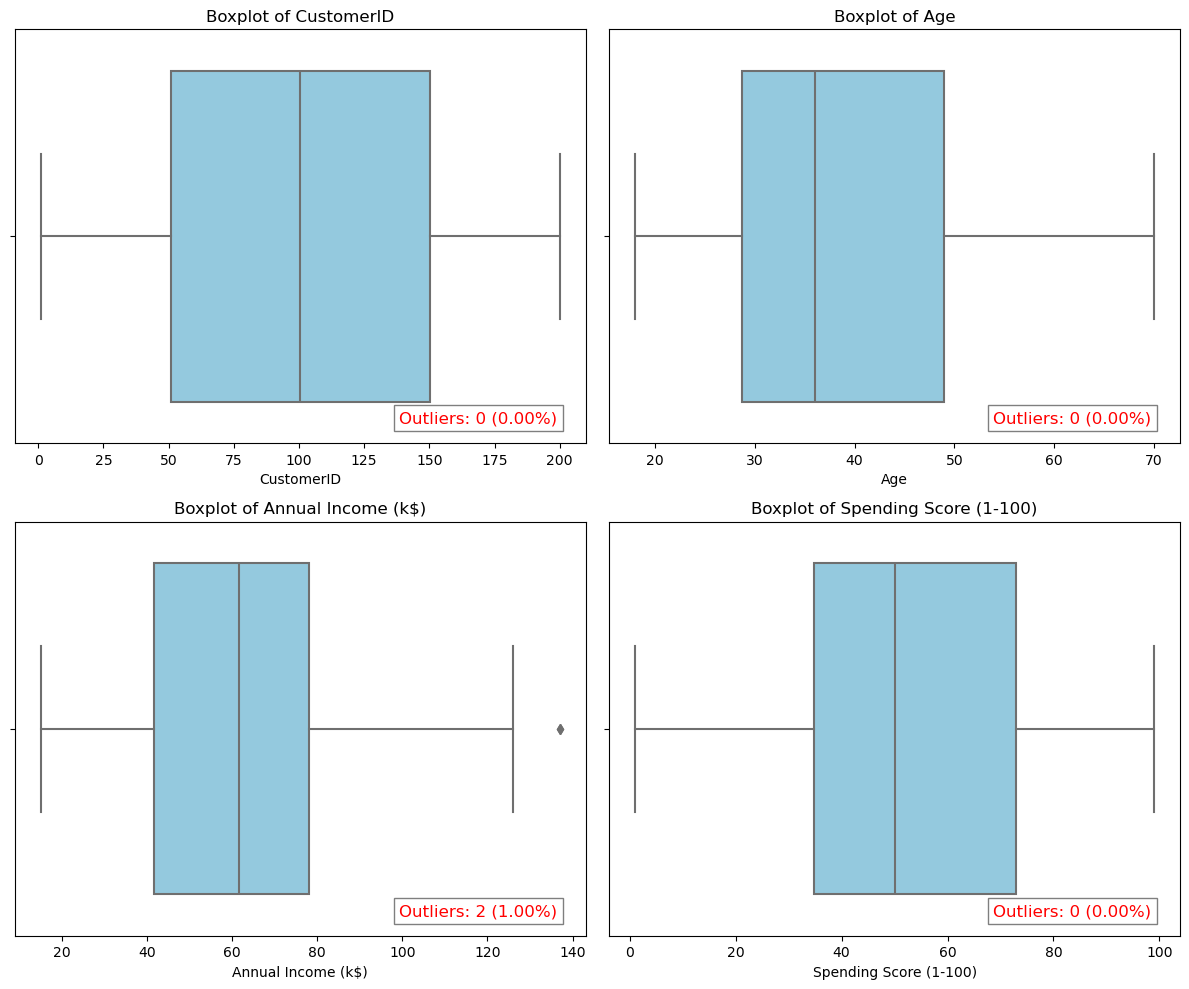

In [18]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Set figure size and number of columns to display
fig, axes = plt.subplots(nrows=len(numerical_cols) // 2 + len(numerical_cols) 
                         % 2, ncols=2, figsize=(12, len(numerical_cols) * 2.5))
axes = axes.flatten()

# Plot individual boxplots for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i], color = "skyblue" )
    axes[i].set_title(f"Boxplot of {col}")

    # Calculate count and percentage of outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_percent = (outlier_count / df[col].count()) * 100

    # Display outlier count and percentage on the plot
    axes[i].text(0.95, 0.05, f"Outliers: {outlier_count} ({outlier_percent:.2f}%)",
                 transform=axes[i].transAxes, fontsize=12, color='red',
                 ha='right', bbox=dict(facecolor='white', alpha=0.5))

# Remove any unused subplots if the number of columns is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 2. Exploratory Data Analysis

In [24]:
#Save orginal data
df0 = df.copy()

# Drop CustomerID column as it is not needed

df = df.drop(columns=['CustomerID'])
df.head()

,Gender,Age,Education,Marital Status,Annual Income (k$),Spending Score (1-100)
0,M,19,High School,Married,15,39
1,M,21,Graduate,Single,15,81
2,F,20,Graduate,Married,16,6
3,F,23,High School,Unknown,16,77
4,F,31,Uneducated,Married,17,40


## Statistical Summary and Distribution Plots for Data Features

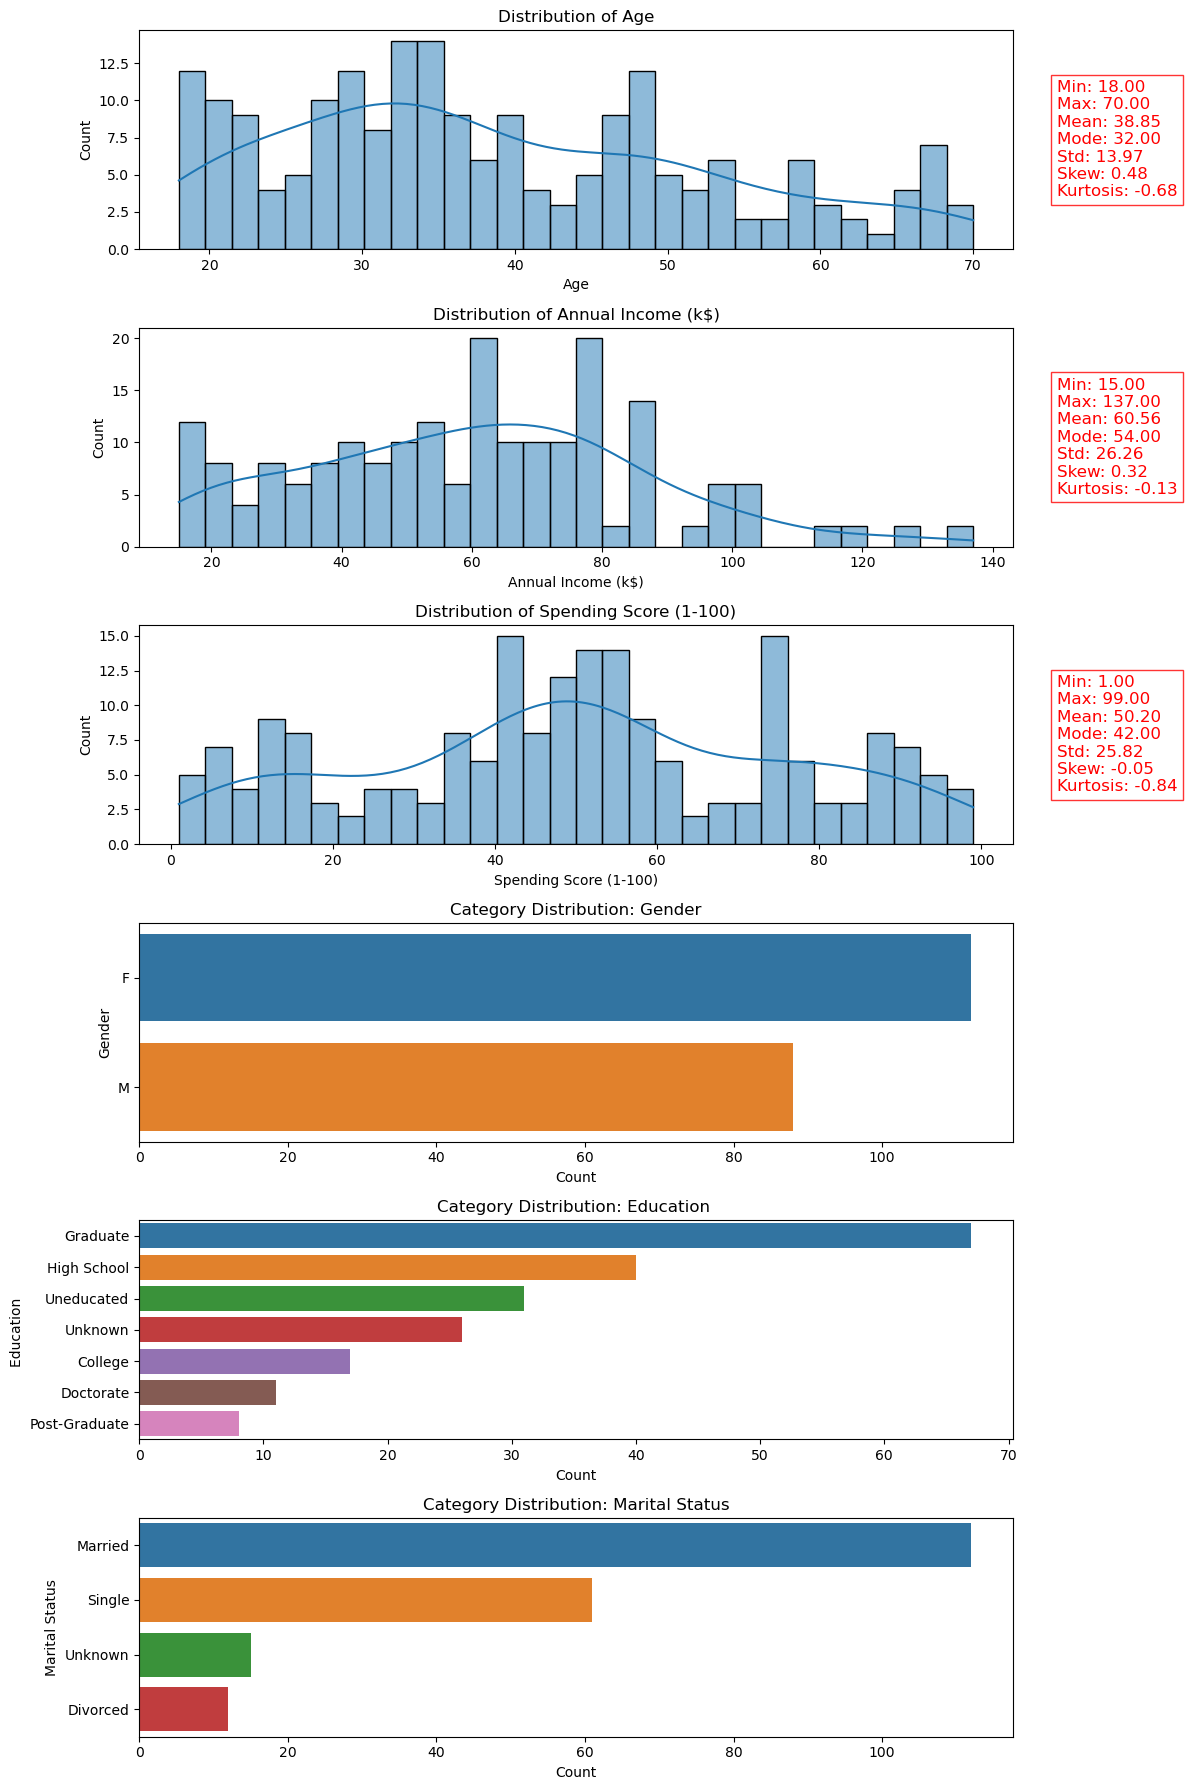

In [28]:
# Plot barcharts and histograms by data type
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Check total number of columns to plot
num_plots = len(numerical_cols) + len(categorical_cols)

if num_plots > 0:
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, num_plots * 3))
    axes = axes.flatten() if num_plots > 1 else [axes]  # Ensure axes is always iterable

    # --- Plot for numerical columns ---
    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")

        # Calculate statistics
        min_val, max_val = df[col].min(), df[col].max()
        mean_val, mode_val = df[col].mean(), df[col].mode()[0]
        std_val, skewness, kurt = df[col].std(), skew(df[col].dropna()), kurtosis(df[col].dropna())

        # Display stats as annotation on the right side of the plot
        stats_text = (f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nMean: {mean_val:.2f}\n"
                      f"Mode: {mode_val:.2f}\nStd: {std_val:.2f}\nSkew: {skewness:.2f}\nKurtosis: {kurt:.2f}")

        axes[i].annotate(stats_text, xy=(1.05, 0.5), xycoords="axes fraction",
                         fontsize=12, color='red', ha='left', va='center',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

    # --- Plot for categorical columns ---
    for j, col in enumerate(categorical_cols, start=len(numerical_cols)):
        value_counts = df[col].value_counts().sort_values(ascending=False)
        sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[j])
        axes[j].set_title(f"Category Distribution: {col}")
        axes[j].set_xlabel("Count")

    plt.tight_layout()
    plt.show()
else:
    print("No numerical or categorical columns to plot!")

## Log Transformation and Distribution Visualization of Numerical Features

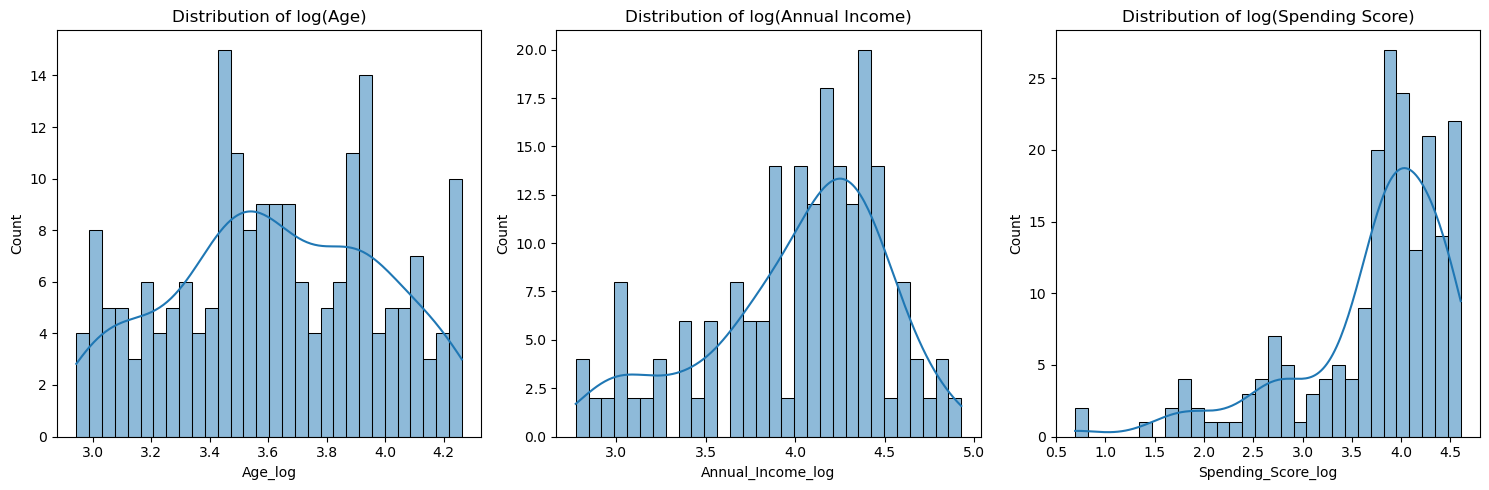

In [29]:
# Apply log transformation to numerical columns
df['Age_log'] = np.log1p(df['Age'])
df['Annual_Income_log'] = np.log1p(df['Annual Income (k$)'])
df['Spending_Score_log'] = np.log1p(df['Spending Score (1-100)'])

# List of columns and their corresponding titles
features = ['Age_log', 'Annual_Income_log', 'Spending_Score_log']
titles = ['Distribution of log(Age)', 'Distribution of log(Annual Income)', 'Distribution of log(Spending Score)']

# Set figure size for the plots
plt.figure(figsize=(15, 5))

# Plot histograms with KDE for each log-transformed feature
for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(titles[i])
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [32]:
# Remove leading/trailing whitespace from column names
df.columns = df.columns.str.strip()  

# Define feature lists
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
nominal_features = [col for col in ['Gender', 'Marital Status', 'Education'] if col in df.columns]

# Standardize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# One-hot encode nominal (categorical) variables
if nominal_features:
    df = pd.get_dummies(df, columns=nominal_features, dtype=int)

# Rename columns to avoid special characters
df.columns = df.columns.str.replace(r'\W+', '_', regex=True)

# Preview the result
df.head()

,Age,Annual_Income_k_,Spending_Score_1_100_,Age_log,Annual_Income_log,Spending_Score_log,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Education_College,Education_Doctorate,Education_Graduate,Education_High_School,Education_Post_Graduate,Education_Uneducated,Education_Unknown
0,-1.424569,-1.738999,-0.434801,2.995732,2.772589,3.688879,0,1,0,1,0,0,0,0,0,1,0,0,0
1,-1.281035,-1.738999,1.195704,3.091042,2.772589,4.406719,0,1,0,0,1,0,0,0,1,0,0,0,0
2,-1.352802,-1.700830,-1.715913,3.044522,2.833213,1.945910,1,0,0,1,0,0,0,0,1,0,0,0,0
3,-1.137502,-1.700830,1.040418,3.178054,2.833213,4.356709,1,0,0,0,0,1,0,0,0,1,0,0,0
4,-0.563369,-1.662660,-0.395980,3.465736,2.890372,3.713572,1,0,0,1,0,0,0,0,0,0,0,1,0


In [33]:
# Use standardized columns from df for clustering
rfm_scaled_df = df[['Age', 'Annual_Income_k_', 'Spending_Score_1_100_']].copy()
rfm_scaled_df.head()

,Age,Annual_Income_k_,Spending_Score_1_100_
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


# 3. Clustering Analysis Implementation

## Elbow Method

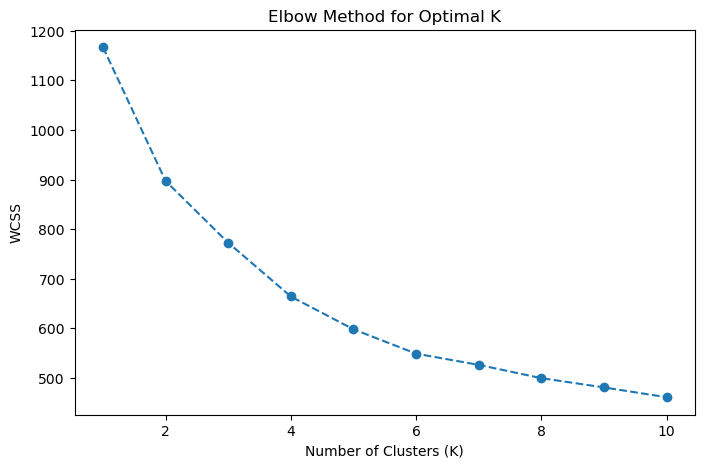

In [38]:
from sklearn.cluster import KMeans

# Find the optimal number of clusters using the Elbow Method
wcss = []  # Within-Cluster Sum of Squares

for k in range(1, 11):  # Try cluster numbers from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[[col for col in df.columns if col != 'cluster']])
    wcss.append(kmeans.inertia_)  # inertia_ is the sum of squared distances within clusters

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.title('Elbow Method for Optimal K')
plt.show()

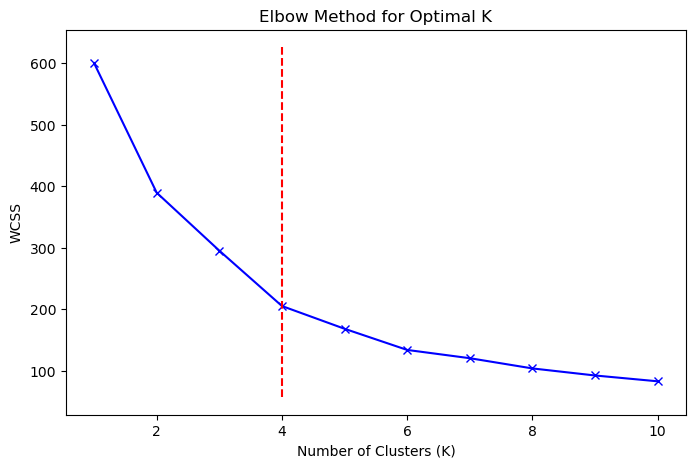

Optimal number of clusters selected: 4


In [39]:
from kneed import KneeLocator

# Define the range of cluster numbers to test
wcss = []
K_range = range(1, 11)  # Testing cluster numbers from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)  # Store the Within-Cluster Sum of Squares (WCSS) for each k

# Automatically find the elbow point
kn = KneeLocator(K_range, wcss, curve='convex', direction='decreasing')

# Plot the Elbow chart
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')

# Draw a vertical line at the elbow point
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.show()

print(f"Optimal number of clusters selected: {kn.knee}")

## K-Mean

In [40]:
# Initialize K-Means with the selected number of clusters (K)
kmeans = KMeans(n_clusters=4, random_state=42)

# Train the model using the normalized columns
rfm_scaled_df['cluster'] = kmeans.fit_predict(
    rfm_scaled_df[['Age', 'Annual_Income_k_', 'Spending_Score_1_100_']]
)

# Check the number of customers in each cluster
print(rfm_scaled_df['cluster'].value_counts())

# Display a few rows of data after clustering
print(rfm_scaled_df.head())

# If you want to perform clustering using both numerical and one-hot encoded categorical features,
# use the entire processed dataset (excluding the cluster column if it already exists)

# Re-create rfm_scaled_df using all feature columns (excluding 'cluster' if it exists)
feature_cols = [col for col in df.columns if col != 'cluster']
rfm_scaled_df_full = df[feature_cols].copy()

# Apply K-Means again using the full feature set
kmeans_full = KMeans(n_clusters=4, random_state=42)
rfm_scaled_df_full['cluster'] = kmeans_full.fit_predict(rfm_scaled_df_full)

# Check cluster sizes using the full dataset
print(rfm_scaled_df_full['cluster'].value_counts())
rfm_scaled_df_full.head()

cluster
3    65
2    57
1    40
0    38
Name: count, dtype: int64
        Age  Annual_Income_k_  Spending_Score_1_100_  cluster
0 -1.424569         -1.738999              -0.434801        2
1 -1.281035         -1.738999               1.195704        2
2 -1.352802         -1.700830              -1.715913        2
3 -1.137502         -1.700830               1.040418        2
4 -0.563369         -1.662660              -0.395980        2
cluster
0    68
3    59
1    40
2    33
Name: count, dtype: int64


,Age,Annual_Income_k_,Spending_Score_1_100_,Age_log,Annual_Income_log,Spending_Score_log,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Education_College,Education_Doctorate,Education_Graduate,Education_High_School,Education_Post_Graduate,Education_Uneducated,Education_Unknown,cluster
0,-1.424569,-1.738999,-0.434801,2.995732,2.772589,3.688879,0,1,0,1,0,0,0,0,0,1,0,0,0,3
1,-1.281035,-1.738999,1.195704,3.091042,2.772589,4.406719,0,1,0,0,1,0,0,0,1,0,0,0,0,3
2,-1.352802,-1.700830,-1.715913,3.044522,2.833213,1.945910,1,0,0,1,0,0,0,0,1,0,0,0,0,3
3,-1.137502,-1.700830,1.040418,3.178054,2.833213,4.356709,1,0,0,0,0,1,0,0,0,1,0,0,0,3
4,-0.563369,-1.662660,-0.395980,3.465736,2.890372,3.713572,1,0,0,1,0,0,0,0,0,0,0,1,0,3


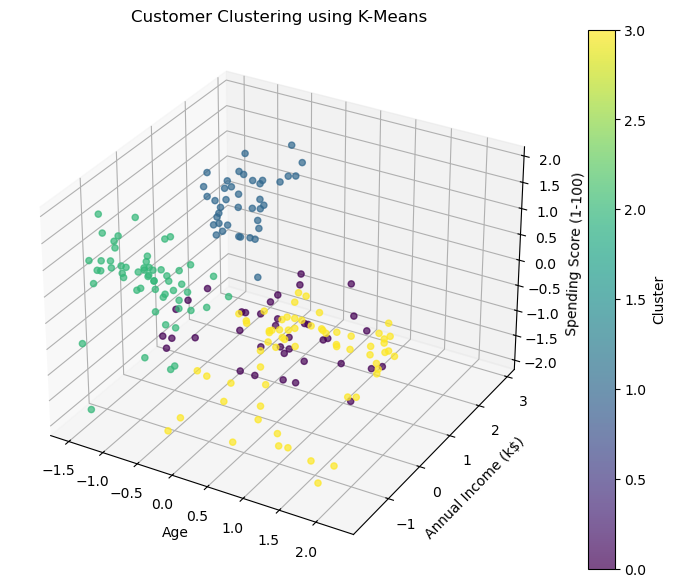

In [41]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure and axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot a 3D scatter plot with colors representing cluster labels
scatter = ax.scatter(
    rfm_scaled_df['Age'],
    rfm_scaled_df['Annual_Income_k_'],
    rfm_scaled_df['Spending_Score_1_100_'],
    c=rfm_scaled_df['cluster'],
    cmap='viridis',
    alpha=0.7
)

# Set axis labels
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Customer Clustering using K-Means')

# Add a legend (colorbar) for cluster labels
legend = plt.colorbar(scatter)
legend.set_label("Cluster")

# Show the plot
plt.show()

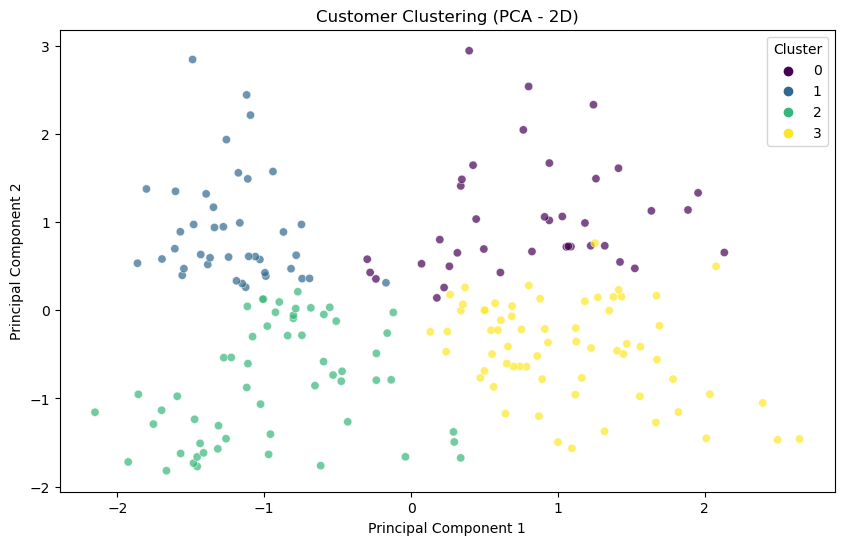

In [42]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled_df[['Age', 'Annual_Income_k_', 'Spending_Score_1_100_']])

# Convert PCA result to a DataFrame
rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
rfm_pca_df['cluster'] = rfm_scaled_df['cluster']

# Plot 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis', alpha=0.7)
plt.title("Customer Clustering (PCA - 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# 4. Strategic Insights for Each Customer Segment (KMeans - PCA 2D)


Following a customer segmentation analysis using KMeans clustering and PCA for dimensionality reduction, customers were classified into **four distinct groups**. Each segment exhibits unique behaviors and financial potential, allowing the bank to tailor strategic initiatives accordingly:

---

## <span style="color:#6A5ACD"><b>Segment 0 – High-Income Customers with Low Spending</b></span>

1. High-income earners who display unusually conservative spending behavior.  
2. Tend to be analytical, financially disciplined, and less influenced by typical marketing.  
3. Often under-engaged but hold high potential if converted.

**Recommended Strategy:**

- Provide exclusive trials or previews of premium financial products.  
- Use personalized data to identify unmet needs and trigger tailored offers.  
- Engage during key life or calendar events with meaningful incentives.

---

## <span style="color:#1E90FF"><b>Segment 1 – Middle-Aged Customers with High Income and High Spending</b></span>

1. Generally in their mid-career stage with stable, high earnings.  
2. Exhibit strong purchasing power and consistent spending habits.  
3. Likely to value quality, exclusivity, and long-term benefits.

**Recommended Strategy:**

- Introduce VIP programs, premium cards, or high-tier loyalty schemes.  
- Provide personalized banking services and dedicated relationship managers.  
- Develop retention strategies through tailored rewards and lifestyle benefits.

---

## <span style="color:#32CD32"><b>Segment 2 – Older Customers with Lower Income and Low Spending</b></span>

1. Senior individuals, often retirees or nearing retirement age.  
2. Lower or fixed incomes, with a strong focus on saving and cautious spending.  
3. Value reliability, trust, and long-term financial security.

**Recommended Strategy:**

- Offer senior-specific savings packages or long-term benefit accounts.  
- Emphasize essential services with favorable pricing.  
- Maintain regular touchpoints through advisory or service support.

---

## <span style="color:#DAA520"><b>Segment 3 – Young Customers with Low Income and High Spending</b></span>

1. Typically younger individuals, such as students or early-career professionals.  
2. Limited income capacity but demonstrate high discretionary spending behavior.  
3. Motivated by novelty, social trends, and experience-based consumption.

**Recommended Strategy:**

- Offer promotions, cashback programs, or small-value incentives.  
- Focus on trend-driven products and digital-first experiences.  
- Leverage social media campaigns and gamified engagement tools.

---

<span style="color:#DC143C"><b>Conclusion</b></span>

Customer segmentation using KMeans clustering, combined with methods such as the Elbow Method (for optimal cluster selection) and PCA (for dimensionality reduction and visualization), provides businesses with data-driven insights into distinct customer behaviors.

These techniques allow to:

- Identify and understand key customer segments based on spending patterns, income levels, and demographics.

- Develop personalized marketing strategies tailored to each segment’s financial behavior and needs.

- Allocate resources more efficiently by focusing on high-value or high-potential customers.

- Enhance customer experience and satisfaction by offering targeted products, services, and communication.

- Drive long-term customer loyalty and profitability by addressing the unique preferences of each group.

In summary, clustering-based segmentation transforms raw customer data into actionable insights, empowering businesses to make smarter, customer-centric decisions.
